# Example of running MOME on a simple Trigonometry problem

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of qdax.core.containers.mome_repertoire failed: Traceback (most recent call last):
  File "/opt/conda/envs/qdaxpy38/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/envs/qdaxpy38/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/conda/envs/qdaxpy38/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/opt/conda/envs/qdaxpy38/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/opt/conda/envs/qdaxpy38/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    ref.__class__ = new
  File "<string>", line 4, in __setattr__
dataclasses.FrozenInstanceError: cannot assign to field '__class__'
]


In [31]:
import jax.numpy as jnp
import jax
import time
from typing import Tuple, Any

from functools import partial

from qdax.core.containers.repertoire import compute_cvt_centroids
from qdax.core.containers.mome_repertoire import MOMERepertoire
from qdax.core.mome import MOME, compute_moqd_metrics, add_init_metrics
from qdax.core.emitters.mutation_operators import (
    polynomial_mutation, 
    polynomial_crossover, 
    isoline_variation
)
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.utils.plotting import plot_2d_map_elites_grid, plot_mome_pareto_fronts

import matplotlib.pyplot as plt

from qdax.types import Fitness, Descriptor, RNGKey, Metrics, ExtraScores

## Define parameters

In [32]:
pareto_front_max_length = 50
num_variables = 100
num_iterations = 1000

num_centroids = 64
minval = -2
maxval = 4
proportion_to_mutate = 0.6
eta = 1
proportion_var_to_change = 0.5
crossover_percentage = 1.
batch_size = 100
lag = 2.2
base_lag = 0
key = jax.random.PRNGKey(42)
descriptor_mode="first"
grid_type = 'voronoi'

## Define the scoring function

In [33]:
def rastrigin_scorer(
    genotypes: jnp.ndarray, base_lag: int, lag: int
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """
    Rastrigin Scorer with first two dimensions as descriptors
    """
    descriptors = genotypes[:, :2]
    f1 = -(
        10 * genotypes.shape[1]
        + jnp.sum(
            (genotypes - base_lag) ** 2
            - 10 * jnp.cos(2 * jnp.pi * (genotypes - base_lag)),
            axis=1,
        )
    )

    f2 = -(
        10 * genotypes.shape[1]
        + jnp.sum(
            (genotypes - lag) ** 2 - 10 * jnp.cos(2 * jnp.pi * (genotypes - lag)),
            axis=1,
        )
    )
    scores = jnp.stack([f1, f2], axis=-1)

    return scores, descriptors

In [34]:
scoring_function = partial(rastrigin_scorer, base_lag=base_lag, lag=lag)

def scoring_fn(genotypes: jnp.ndarray, random_key: RNGKey) -> Tuple[Fitness, Descriptor, ExtraScores, RNGKey]:
    fitnesses, descriptors = scoring_function(genotypes)
    return fitnesses, descriptors, {}, random_key

## Define the emitter

In [35]:
crossover_function = partial(
    polynomial_crossover,
    proportion_var_to_change=proportion_var_to_change
)

mutation_function = partial(
    polynomial_mutation,
    eta=eta,
    minval=minval,
    maxval=maxval,
    proportion_to_mutate=proportion_to_mutate
)

line_crossover_function = partial(
    isoline_variation,
    iso_sigma=0.005,
    line_sigma=0.05,
)

In [36]:
# Define emitter
#variation_fn = functools.partial(
#    isoline_variation, iso_sigma=0.005, line_sigma=0.05
#)
mixing_emitter = MixingEmitter(
    mutation_fn=mutation_function, 
    variation_fn=crossover_function, 
    variation_percentage=crossover_percentage, 
    batch_size=batch_size
)

## Compute the centroids

In [37]:
%%time

init_time = time.time()
centroids = compute_cvt_centroids(
    num_descriptors=2, 
    num_init_cvt_samples=20000, 
    num_centroids=num_centroids, 
    minval=minval, 
    maxval=maxval
)
duration = time.time() - init_time
print(f'Computed centroids in {duration:.2f}s')
centroids = centroids[jnp.argsort(centroids[:, 0])]

Computed centroids in 3.31s
CPU times: user 1min, sys: 12.6 s, total: 1min 12s
Wall time: 3.31 s


## Define the metrics function

In [38]:
my_boolean = False
if my_boolean:
    x, y = jnp.arange(-5, 5, step=0.2), jnp.arange(-5, 5, step=0.2)

    #Score
    all_enumerations = jnp.array([[(x[i], y[j]) for j in range(len(x))] for i in range(len(x))])
    all_enumerations = jnp.concatenate(all_enumerations)
    all_scores = scorer.compute_scores(all_enumerations)
    reference_point = jnp.array([jnp.min(all_scores[:, 0]), jnp.min(all_scores[:, 1])])
else:
    reference_point = jnp.array([ -150, -150])

# how to compute metrics from a repertoire
metrics_function = partial(
    compute_moqd_metrics,
    reference_point=reference_point
)

## Define a MOME instance

In [47]:
mome = MOME(
    scoring_function=scoring_fn,
    emitter=mixing_emitter,
    metrics_function=metrics_function,
)

## Initiate a population and init the algorithm

In [48]:
random_key = jax.random.PRNGKey(42)
random_key, subkey = jax.random.split(random_key)
init_genotypes = jax.random.uniform(
    random_key, (batch_size, num_variables), minval=minval, maxval=maxval, dtype=jnp.float32
)

[autoreload of qdax.core.containers.mome_repertoire failed: Traceback (most recent call last):
  File "/opt/conda/envs/qdaxpy38/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/envs/qdaxpy38/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/conda/envs/qdaxpy38/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/opt/conda/envs/qdaxpy38/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/opt/conda/envs/qdaxpy38/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    ref.__class__ = new
  File "<string>", line 4, in __setattr__
dataclasses.FrozenInstanceError: cannot assign to field '__class__'
]


In [49]:
repertoire, emitter_state, random_key = mome.init(
    init_genotypes,
    centroids,
    pareto_front_max_length,
    random_key
)

Cell fitness shape :  Traced<ShapedArray(float32[1,50,2])>with<DynamicJaxprTrace(level=1/2)>
Fitness shape :  (2,)
Cell genotype shape :  Traced<ShapedArray(float32[1,50,100])>with<DynamicJaxprTrace(level=1/2)>
Cell descriptor shape :  Traced<ShapedArray(float32[1,50,2])>with<DynamicJaxprTrace(level=1/2)>
------------------------------------------------------------------------------------------------------------------------------------------------------
carry genotypes :  Traced<ShapedArray(float32[64,50,100])>with<DynamicJaxprTrace(level=1/2)>
cell genotype :  Traced<ShapedArray(float32[50,100])>with<DynamicJaxprTrace(level=1/2)>
carry fitnesses :  Traced<ShapedArray(float32[64,50,2])>with<DynamicJaxprTrace(level=1/2)>
cell fitness :  Traced<ShapedArray(float32[50,2])>with<DynamicJaxprTrace(level=1/2)>
carry descriptors :  Traced<ShapedArray(float32[64,50,2])>with<DynamicJaxprTrace(level=1/2)>
cell desc :  Traced<ShapedArray(float32[50,2])>with<DynamicJaxprTrace(level=1/2)>


## Run MOME iterations

In [50]:
%%time

# Run the algorithm
(repertoire, emitter_state, random_key,), metrics = jax.lax.scan(
    mome.scan_update,
    (repertoire, emitter_state, random_key),
    (),
    length=num_iterations,
)

BEautiful fitness :  Traced<ShapedArray(float32[64,50,2])>with<DynamicJaxprTrace(level=1/4)>
Grid empty shaaape :  Traced<ShapedArray(bool[64,50])>with<DynamicJaxprTrace(level=1/4)>
Probability :  Traced<ShapedArray(float32[64])>with<DynamicJaxprTrace(level=1/4)>
My sampled elements :  Traced<ShapedArray(float32[100,1,100])>with<DynamicJaxprTrace(level=1/4)>
My random keys :  Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace(level=1/4)>
BEautiful fitness :  Traced<ShapedArray(float32[64,50,2])>with<DynamicJaxprTrace(level=1/4)>
Grid empty shaaape :  Traced<ShapedArray(bool[64,50])>with<DynamicJaxprTrace(level=1/4)>
Probability :  Traced<ShapedArray(float32[64])>with<DynamicJaxprTrace(level=1/4)>
My sampled elements :  Traced<ShapedArray(float32[100,1,100])>with<DynamicJaxprTrace(level=1/4)>
My random keys :  Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace(level=1/4)>
Cell fitness shape :  Traced<ShapedArray(float32[1,50,2])>with<DynamicJaxprTrace(level=2/3)>
Fitness shape :  (2

## Visualise results

In [43]:
moqd_scores = jnp.sum(metrics.moqd_score, where=metrics.moqd_score!=-jnp.inf, axis=-1)

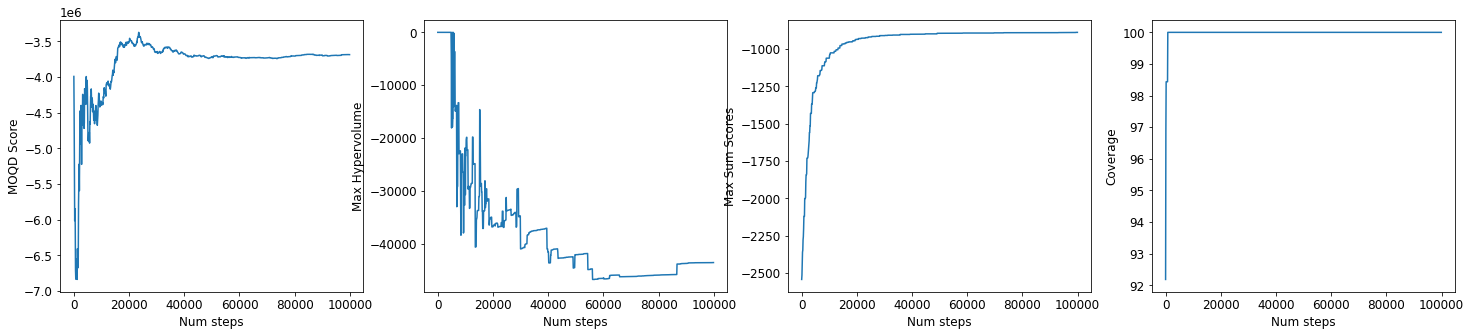

In [44]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 5))

steps = batch_size * jnp.arange(start=0, stop=num_iterations)
ax1.plot(steps, moqd_scores)
ax1.set_xlabel('Num steps')
ax1.set_ylabel('MOQD Score')

ax2.plot(steps, metrics.max_hypervolume)
ax2.set_xlabel('Num steps')
ax2.set_ylabel('Max Hypervolume')

ax3.plot(steps, metrics.max_sum_scores)
ax3.set_xlabel('Num steps')
ax3.set_ylabel('Max Sum Scores')

ax4.plot(steps, metrics.coverage)
ax4.set_xlabel('Num steps')
ax4.set_ylabel('Coverage')
plt.show()

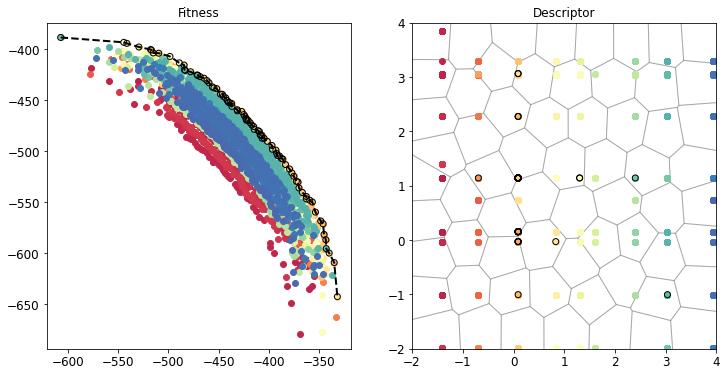

In [45]:
fig, axes = plt.subplots(figsize=(12, 6), ncols=2)
plot_mome_pareto_fronts(
    centroids,
    repertoire,
    minval=minval,
    maxval=maxval,
    color_style='spectral',
    axes=axes,
    with_global=True
)
plt.show()

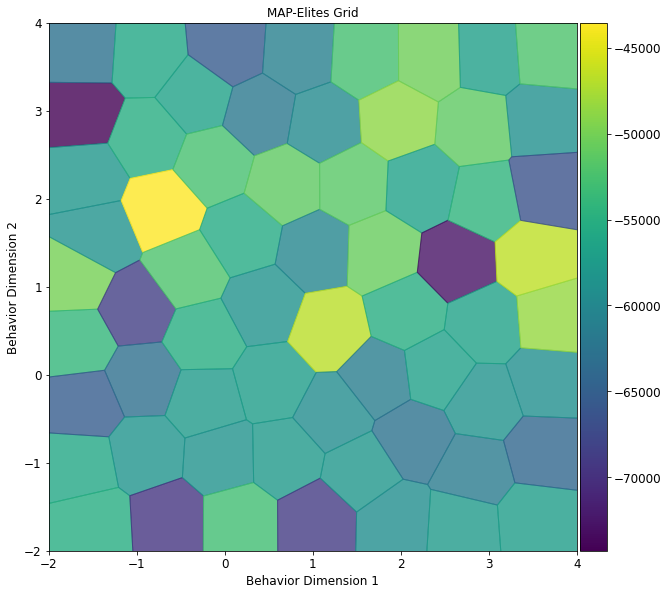

In [46]:
plot_2d_map_elites_grid(
    centroids=centroids,
    grid_fitness=metrics.moqd_score[-1],
    minval=minval,
    maxval=maxval,
)
plt.show()